### Random Forest

In [2]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json, auto_cast, challenge_champion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import json
import mlflow
import numpy as np
import optuna
import pandas as pd
import pickle

Load the datasets for training (remember they are scaled)

In [3]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [4]:
# The scores we want to look at
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

#### Hyperparameter Tuning
First, lets set up MLflow

In [5]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

In [6]:
client = mlflow.tracking.MlflowClient()

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [7]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1764788131496, experiment_id='1', last_update_time=1764788131496, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.experimentKind': 'custom_model_development',
 'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

Here we set up the hyperparameters we want to tune

In [8]:
base_run_name = "random_forest"

In [9]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'random_forest': 0


In [10]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'random_forest_v1'

In [11]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        max_depth = trial.suggest_categorical(
            "max_depth",
            [None] + list(range(5, 51))
        )
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': max_depth,
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
        }

        # Initialize the model
        model = RandomForestClassifier(**params, random_state=42)

        # Train the model
        model.fit(X_train, Y_train)

        # Evaluate the model
        preds = model.predict(X_val)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(params)
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        return metrics['f1']

In [12]:
artifact_path = "model"
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=exp_id, run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    # Initialize the Optuna study
    study = optuna.create_study(direction='maximize', study_name='RandomForest_Optimization')
    # Execute the hyperparameter optimization trials.
    study.optimize(objective, n_trials=20)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", study.best_value)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "RandomForestClassifier",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    model = RandomForestClassifier(**study.best_params, random_state=42)
    model.fit(X_train, Y_train)

    # Log the final model
    model_info = mlflow.sklearn.log_model(model, 
                             artifact_path=artifact_path,
                             input_example=X_train.iloc[[0]],
                             registered_model_name="RandomForest_Credit_Card_Approval",
                             tags={"project": "Credit Card Approval",
                                   "model_family": "RandomForestClassifier"
                                   }
                             )
    model_uri = model_info.model_uri

[I 2025-12-16 20:28:53,961] A new study created in memory with name: RandomForest_Optimization
[I 2025-12-16 20:29:24,334] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 42, 'n_estimators': 122, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run unleashed-loon-878 at: http://127.0.0.1:8080/#/experiments/1/runs/e2b2a56c0c4b4b96a784ec99f1c92bd9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:29:51,562] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 43, 'n_estimators': 147, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.0.


🏃 View run silent-ape-232 at: http://127.0.0.1:8080/#/experiments/1/runs/a11d1cf5ca1c4323bdfbf16f1e2c792b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:30:28,814] Trial 2 finished with value: 0.2222222222222222 and parameters: {'max_depth': 36, 'n_estimators': 187, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.2222222222222222.


🏃 View run polite-hawk-690 at: http://127.0.0.1:8080/#/experiments/1/runs/a889106d85c949e4b785a31f6fa1758d
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:30:57,883] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 19, 'n_estimators': 134, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 2 with value: 0.2222222222222222.


🏃 View run righteous-roo-890 at: http://127.0.0.1:8080/#/experiments/1/runs/74bfdb64102d412c8113019e0991b21b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:31:58,432] Trial 4 finished with value: 0.25766871165644173 and parameters: {'max_depth': 32, 'n_estimators': 254, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run dapper-horse-96 at: http://127.0.0.1:8080/#/experiments/1/runs/4c34a73a110c4a6685e53c969b4bfab0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:32:07,443] Trial 5 finished with value: 0.0 and parameters: {'max_depth': 45, 'n_estimators': 54, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run gaudy-lark-99 at: http://127.0.0.1:8080/#/experiments/1/runs/08773662fec5412581d620146bb4e4a5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:32:24,382] Trial 6 finished with value: 0.006696428571428571 and parameters: {'max_depth': 5, 'n_estimators': 219, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run respected-bass-59 at: http://127.0.0.1:8080/#/experiments/1/runs/0b48c447bc604b159aca783d5e74da75
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:32:39,973] Trial 7 finished with value: 0.20915032679738563 and parameters: {'max_depth': 17, 'n_estimators': 132, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run resilient-shrew-918 at: http://127.0.0.1:8080/#/experiments/1/runs/d3283d0a50014514a6ae5ceb8d0180db
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:32:44,522] Trial 8 finished with value: 0.05730659025787966 and parameters: {'max_depth': 10, 'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run glamorous-koi-998 at: http://127.0.0.1:8080/#/experiments/1/runs/091dbf2be1bb4007b6394ad72c70e449
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:32:56,663] Trial 9 finished with value: 0.0 and parameters: {'max_depth': 8, 'n_estimators': 106, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': None}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run intelligent-lynx-403 at: http://127.0.0.1:8080/#/experiments/1/runs/ecb46f6c69dc4324bac50095c8ff73a2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:33:41,162] Trial 10 finished with value: 0.22929936305732485 and parameters: {'max_depth': 32, 'n_estimators': 281, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run wistful-grouse-390 at: http://127.0.0.1:8080/#/experiments/1/runs/93089554196644f1b00ce4cd910be9b7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:34:27,732] Trial 11 finished with value: 0.22929936305732485 and parameters: {'max_depth': 32, 'n_estimators': 294, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run gifted-calf-600 at: http://127.0.0.1:8080/#/experiments/1/runs/4737a4830ced43e69dba95d0ed464e10
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:35:13,742] Trial 12 finished with value: 0.23076923076923078 and parameters: {'max_depth': 32, 'n_estimators': 289, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run amazing-duck-854 at: http://127.0.0.1:8080/#/experiments/1/runs/24d246ea04f6430bb58d4c9c20a882db
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:35:51,043] Trial 13 finished with value: 0.21935483870967742 and parameters: {'max_depth': 18, 'n_estimators': 251, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run adventurous-boar-207 at: http://127.0.0.1:8080/#/experiments/1/runs/6867744b59f74c92a7635193f6d072f0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:36:50,634] Trial 14 finished with value: 0.21794871794871795 and parameters: {'max_depth': 49, 'n_estimators': 248, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run unequaled-gull-957 at: http://127.0.0.1:8080/#/experiments/1/runs/c43eaace292c49158e5786c1bf1fade2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:37:31,552] Trial 15 finished with value: 0.22784810126582278 and parameters: {'max_depth': 40, 'n_estimators': 258, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run marvelous-snake-742 at: http://127.0.0.1:8080/#/experiments/1/runs/308fba4745984d148ea09c03d4454296
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:38:05,212] Trial 16 finished with value: 0.23225806451612904 and parameters: {'max_depth': 47, 'n_estimators': 210, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run sassy-quail-725 at: http://127.0.0.1:8080/#/experiments/1/runs/413566cdf6b746c4ad3903c6b4d3bb9a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:38:54,312] Trial 17 finished with value: 0.21794871794871795 and parameters: {'max_depth': 47, 'n_estimators': 206, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run rogue-midge-620 at: http://127.0.0.1:8080/#/experiments/1/runs/8016d37917c44b2aad72448c9859452a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:39:37,363] Trial 18 finished with value: 0.25766871165644173 and parameters: {'max_depth': 31, 'n_estimators': 227, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run intrigued-shad-487 at: http://127.0.0.1:8080/#/experiments/1/runs/f551750330d343a2894701e7e2b4c6d2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


[I 2025-12-16 20:40:09,852] Trial 19 finished with value: 0.25609756097560976 and parameters: {'max_depth': 31, 'n_estimators': 169, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 4 with value: 0.25766871165644173.


🏃 View run adorable-flea-561 at: http://127.0.0.1:8080/#/experiments/1/runs/7fd6b699125b409890a668e9cae6aa63
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


2025/12/16 20:41:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/ykh/miniconda3/envs/tfgpu/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred sche

🏃 View run random_forest_v1 at: http://127.0.0.1:8080/#/experiments/1/runs/3369eb99d885477ba92e741ce641fcbd
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [13]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 3369eb99d885477ba92e741ce641fcbd
model_uri: models:/m-c2388b1fbbda43888789b0fc456ab6bd


In [14]:
model_name = "Credit_Card_Approval_RandomForest"
challenger = mlflow.register_model(
    model_uri = model_uri, 
    name = model_name, 
    tags={
        "project": "Credit Card Approval",
        "model_family": "RandomForestClassifier"
    }
)

client.set_registered_model_alias(
    name=model_name,
    alias="challenger",
    version=challenger.version
)

Successfully registered model 'Credit_Card_Approval_RandomForest'.
2025/12/16 20:41:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Credit_Card_Approval_RandomForest, version 1
Created version '1' of model 'Credit_Card_Approval_RandomForest'.


In [15]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [16]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.bootstrap,params.n_estimators,params.class_weight,params.min_samples_leaf,params.max_depth,params.max_features,params.min_samples_split
1,f551750330d343a2894701e7e2b4c6d2,0.257669,0.437500,0.182609,0.996453,False,227,balanced,7,31,log2,3
15,4c34a73a110c4a6685e53c969b4bfab0,0.257669,0.437500,0.182609,0.996453,False,254,balanced,9,32,sqrt,3
0,7fd6b699125b409890a668e9cae6aa63,0.256098,0.437500,0.181034,0.996424,False,169,balanced,9,31,log2,6
3,413566cdf6b746c4ad3903c6b4d3bb9a,0.232258,0.375000,0.168224,0.996512,True,210,balanced,6,47,sqrt,3
7,24d246ea04f6430bb58d4c9c20a882db,0.230769,0.375000,0.166667,0.996483,True,289,balanced,6,32,sqrt,4
8,4737a4830ced43e69dba95d0ed464e10,0.229299,0.375000,0.165138,0.996453,True,294,balanced,8,32,sqrt,4
9,93089554196644f1b00ce4cd910be9b7,0.229299,0.375000,0.165138,0.996453,True,281,balanced,8,32,sqrt,4
4,308fba4745984d148ea09c03d4454296,0.227848,0.375000,0.163636,0.996424,True,258,balanced,9,40,sqrt,5
17,a889106d85c949e4b785a31f6fa1758d,0.222222,0.354167,0.161905,0.996512,False,187,balanced,1,36,log2,2
6,6867744b59f74c92a7635193f6d072f0,0.219355,0.354167,0.158879,0.996453,True,251,balanced,6,18,sqrt,6


From the results above, we can see that using class_weight='balanced' is clearly best, which is not surprising, since we have a imbalanced dataset. 
<br>Next, we see that the higher values for min_samples_leaf is in the top. You could try to tune some more, with some higher values in min_samples_leaf, if you wanna see how much it could improve the model. We will however not do that here.
<br>Note also the accuracy for every model. The vast majority got an accuracy of 99% and even the models not predicting 1 risky customer right got it. 

Lets take the model with the hyperparameters that performed the best and test it on our test set and see how well it is doing.

In [17]:
loaded_model = mlflow.sklearn.load_model(model_uri)

In [18]:
# Predict on the val set
val_predictions = loaded_model.predict_proba(X_val)[:, 1]

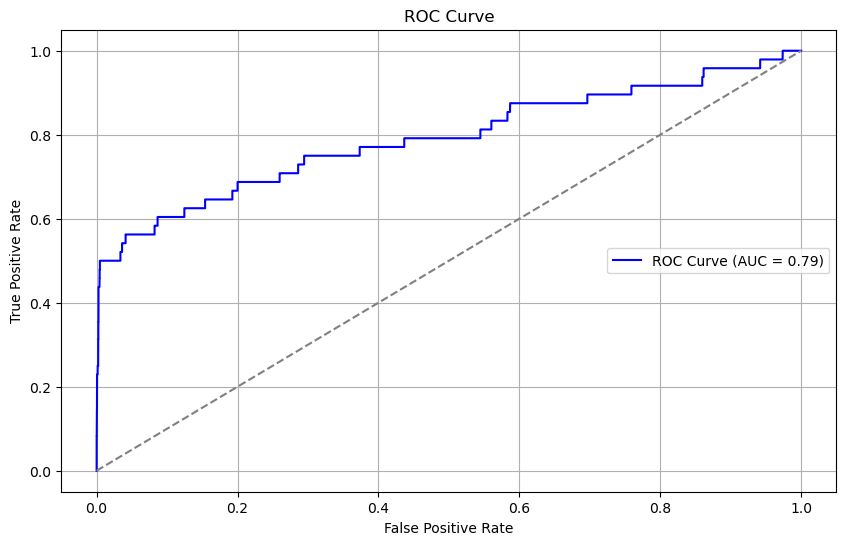

0.7915110434399765

In [19]:
plot_roc_curve(Y_val, val_predictions)

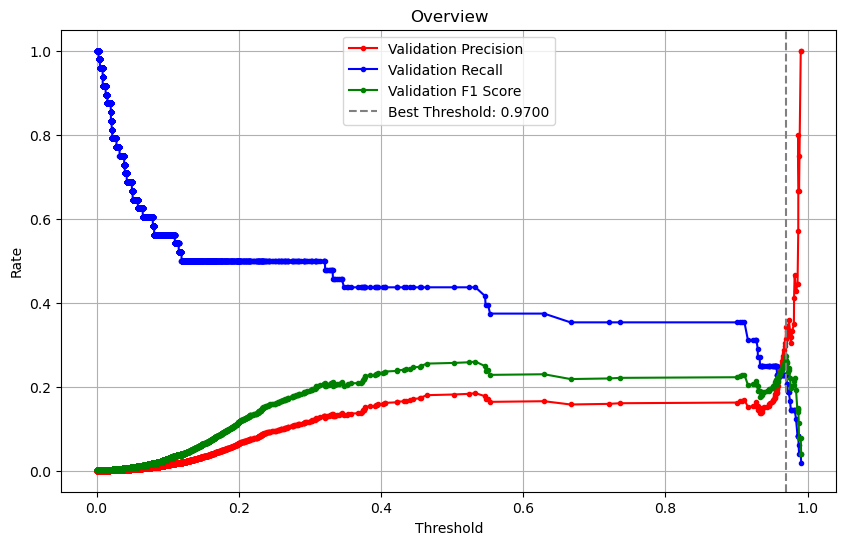

In [20]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)
client.log_param(parent_run_id, 'best_threshold', best_threshold)
client.set_model_version_tag(
    name=model_name,
    version=challenger.version,
    key="best_threshold",
    value=str(best_threshold)
)

In [21]:
# Predict on the test set
test_predictions = loaded_model.predict_proba(X_test)[:, 1]

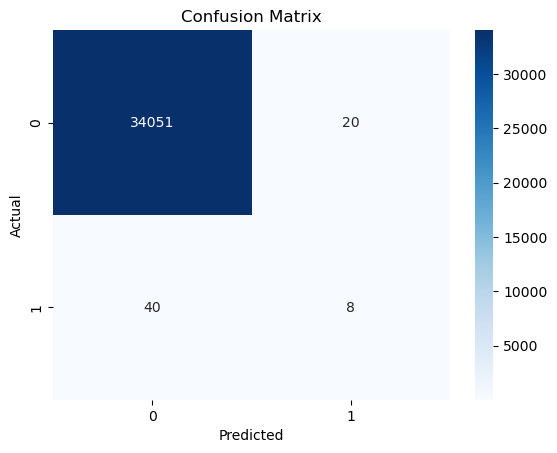

Accuracy     = 1.0
Recall       = 0.17
Precision    = 0.29
F1           = 0.21


In [22]:
challenger_result = get_result(Y_test, test_predictions, best_threshold, visualize=True)

Lets see if it's better than the current champion model (if this is not the first time running)

In [23]:
challenge_champion(
    client, 
    algorithm_name = 'randomforest',
    model_name = model_name, 
    X_test = X_test,
    Y_test = Y_test, 
    challenger_metrics = challenger_result, 
    competing_metric = 'f1'
)

No existing champion model found.
Setting current model as champion.


### Train on both training and validation set

Training the previous model we did not use the validation set, which contains 10% of the original dataset. It could be interresting to see if the model, with the same parameters, could perform better on the test set if it had more data to train on. We'll keep the best threshold, since the model now have seen the data to construct the best threshold and thus be more sure than wants best in general.

Lets merge the training and validation set and predict on the test set again.

In [24]:
best_run = mlflow.get_run(parent_run_id)
best_params = best_run.data.params
best_params = {k: auto_cast(v) for k, v in best_params.items()}
best_params

{'max_depth': 32,
 'n_estimators': 254,
 'min_samples_split': 3,
 'min_samples_leaf': 9,
 'max_features': 'sqrt',
 'bootstrap': False,
 'class_weight': 'balanced',
 'best_threshold': 0.9700195366168178}

In [ ]:
# Remove best_threshold from best_params
best_params.pop('best_threshold', None)

0.9700195366168178

In [28]:
# Initialize the RandomForestClassifier with the best hyperparameters from the tuning phase
rfc = RandomForestClassifier(**best_params)

In [29]:
# Train the model
rfc.fit(pd.concat([X_train, X_val]), pd.concat([Y_train, Y_val]))

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=32,
                       min_samples_leaf=9, min_samples_split=3,
                       n_estimators=254)

In [30]:
# Predict on the val set
val_predictions = rfc.predict_proba(X_val)[:, 1]

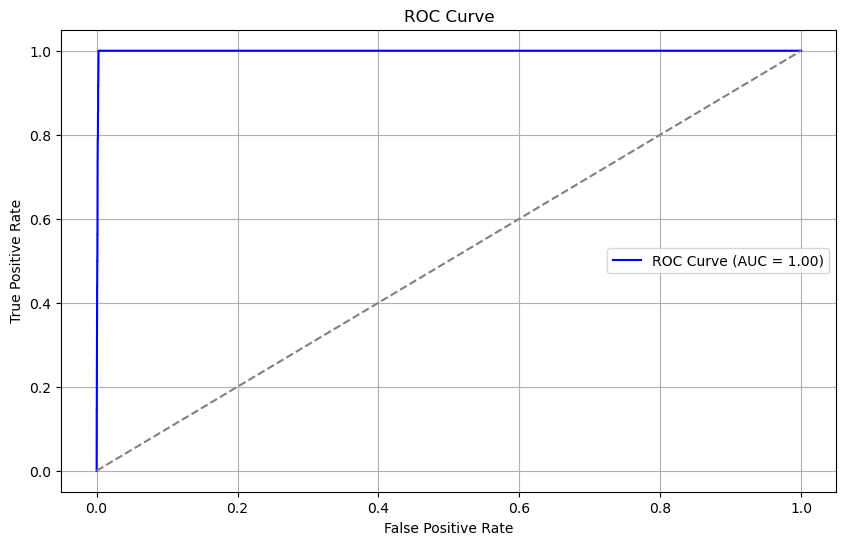

0.9989696458272185

In [31]:
plot_roc_curve(Y_val, val_predictions)

It does perfect on the ROC Curve, which is not surprising, since the model has been trained on the data

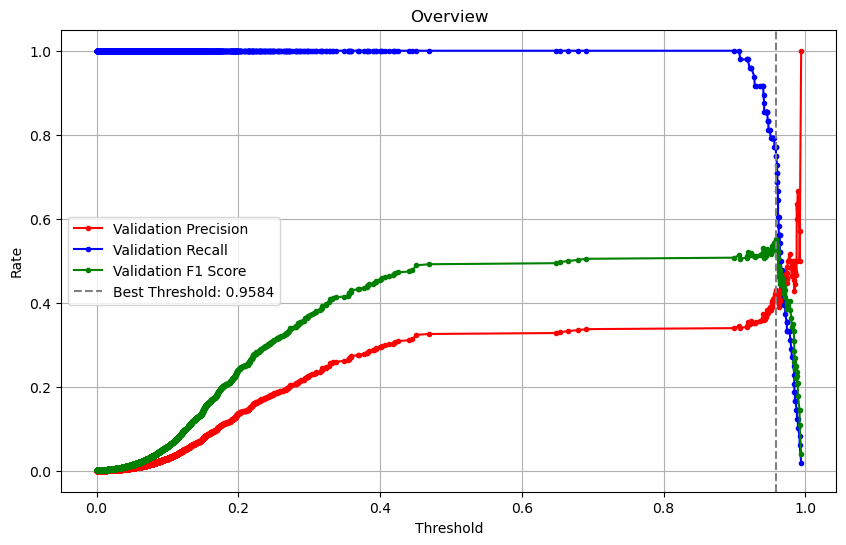

In [32]:
_ = get_best_threshold('Validation', Y_val, val_predictions)

In [33]:
# Predict on the test set
test_predictions = rfc.predict_proba(X_test)[:, 1]

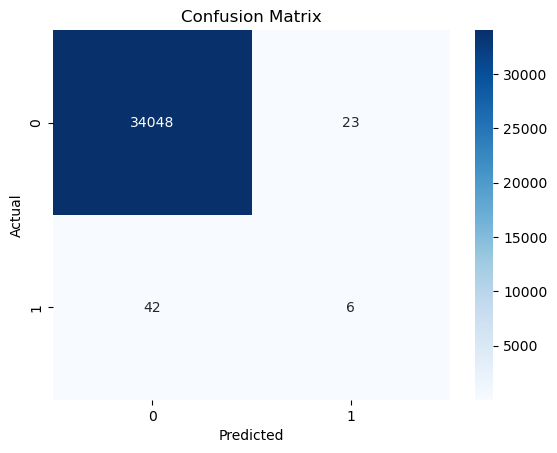

Accuracy     = 1.0
Recall       = 0.12
Precision    = 0.21
F1           = 0.16


In [34]:
result_2 = get_result(Y_test, test_predictions, best_threshold, visualize=True)

In [35]:
if result_2['f1'] > challenger_result['f1']:
    print('By training our model on more data, we achived a higher performance on the F1 score')
else:
    print('The first model we found, through hyperparameter tuning, is still our best model on the F1 score.')
    print('It had the following scores:')
    print('Recall       =', round(challenger_result['recall'], 2))
    print('Precision    =', round(challenger_result['precision'], 2))
    print('F1           =', round(challenger_result['f1'], 2))

The first model we found, through hyperparameter tuning, is still our best model on the F1 score.
It had the following scores:
Recall       = 0.17
Precision    = 0.29
F1           = 0.21
